In [205]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
# hyperparameters

block_size = 3 # the number of words we use for our context
dimensionality = 2 # the number of dimensions in our model
n_neurons_hidden_layer = 100
dictionary_size = 27
batch_size = 32
max_steps = 1000

In [207]:
words = open('names.txt', 'r').read().splitlines() #load our dataset
words[:1]

['emma']

In [208]:
stoi = {s: i+1 for i, s in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()} #create our dictionary

In [209]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape) # should be (vocab_size, block_size) and (vocab_size)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [210]:
x = [[1,2], [3,4], [5,6]] 
torch.tensor(x).shape #shape prints the number of elements in the top layer first, followed by the number in each sublayer.

torch.Size([3, 2])

In [211]:
C = torch.randn((27, dimensionality))
C.shape

torch.Size([27, 2])

In [212]:
emb = C[Xtr][:1]
emb.shape

torch.Size([1, 3, 2])

In [213]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)

# Weights and biases for our first layer
W1 = torch.randn((block_size * dimensionality, n_neurons_hidden_layer), generator=g) * (5/3) / ((dimensionality * block_size) ** 0.5)
b1 = torch.randn(n_neurons_hidden_layer, generator=g) * 0.01

# Weights and biases for our second layer
W2 = torch.randn((n_neurons_hidden_layer, dictionary_size), generator=g) * 0.01
b2 = torch.randn(dictionary_size, generator=g) * 0 # zero out the bias at initialization since we don't want to be adding random numbers in
# we do NOT want to zero out the weights of the nn themselves, though 

In [214]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) 
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0092) tensor(1.0054)
tensor(0.0026) tensor(3.1284)


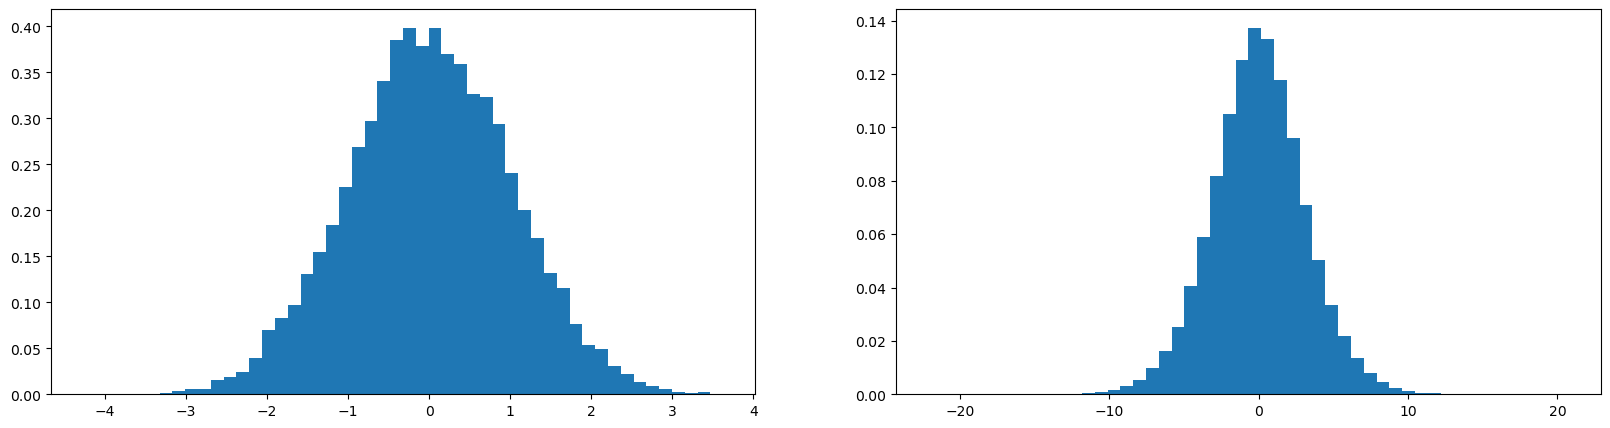

In [215]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [216]:


bngain = torch.ones((1, n_neurons_hidden_layer))
bnbias = torch.zeros((1, n_neurons_hidden_layer))
bnmean_running = torch.zeros((1, n_neurons_hidden_layer))
bnstd_running = torch.ones((1, n_neurons_hidden_layer))

parameters = [C, W1, W2, b2] # all pointers. python is like scheme; all is pointer.
# b1

for p in parameters:
    p.requires_grad = True

In [217]:
stepi = []
lossi = []
max_steps = 100000

In [218]:
for i in range(max_steps):

    # minibatch construct (making the minibatches)
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g) # I defined batch_size as a hyperparameter way up when
    Xb, Yb = Xtr[ix], Ytr[ix] # our batch ok seems good 

    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1) #emb.shape[0] should return 6 here since we're looking 3 words back

    hpreact = embcat @ W1 # + b1 hidden layer pre-activation (remove the b1 because it's nuked by batchnorm)

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        # very weirdly the random selection of our batches introduces some entropy into our dataset, which makes it harder for the the nn to overfit (batchnorm is also a regularizer)
        # how might we have predicted this in advance?

    # these calculations are NOT part of our graph, we just update them at the same time.
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # zero grad
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
        p.data += -lr * p.grad


    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.item())

      0/ 100000: 3.2839
  10000/ 100000: 2.8262
  20000/ 100000: 2.4979
  30000/ 100000: 2.5166
  40000/ 100000: 2.3148
  50000/ 100000: 2.3804
  60000/ 100000: 2.7085
  70000/ 100000: 2.3074
  80000/ 100000: 2.2602
  90000/ 100000: 2.4597


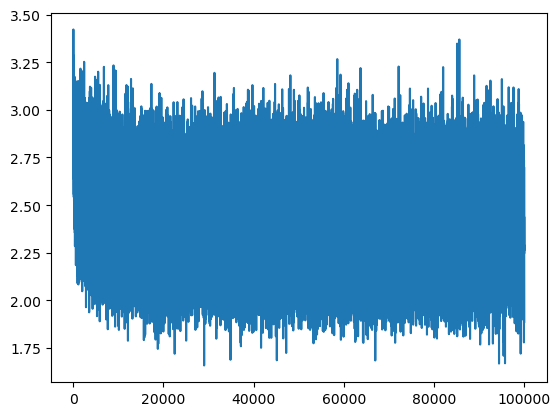

In [219]:
plt.plot(lossi)

In [220]:
# we would like a uniform probability distribution @ the start.
# saves us from having to correct arbitrary biases from random initalization (the hockey stick)

In [221]:
# for loops are not closures! only functions & classes create new scopes in python, for, while, if, with do not.
h.shape

torch.Size([32, 100])

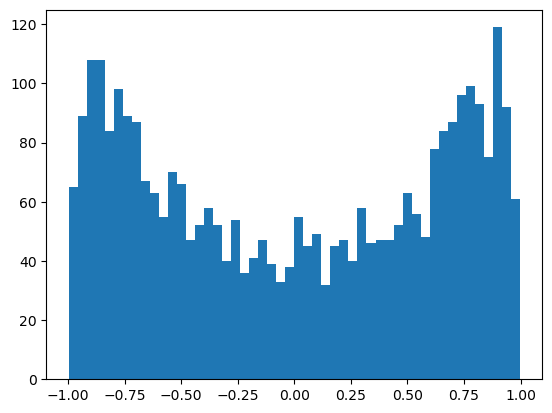

In [222]:
plt.hist(h.view(-1).tolist(), 50);

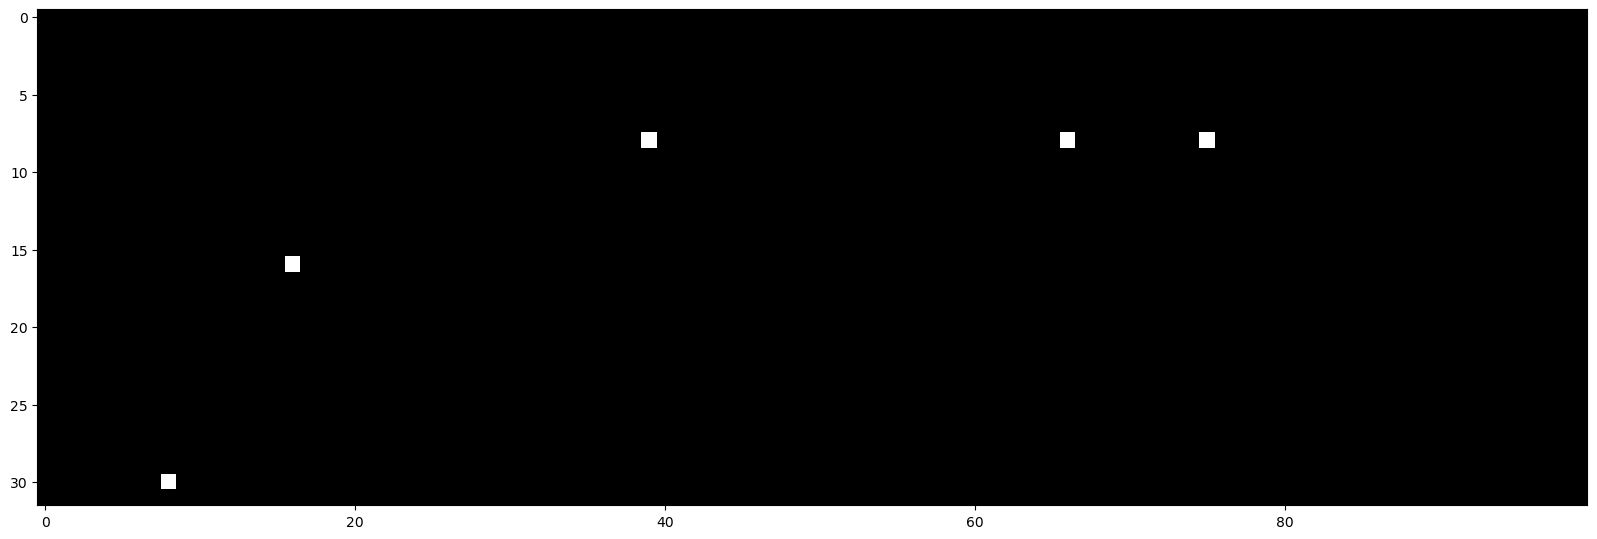

In [223]:
# minibatch construct (making the minibatches)
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g) # I defined batch_size as a hyperparameter way up when
Xb, Yb = Xtr[ix], Ytr[ix] # our batch ok seems good 

emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) #emb.shape[0] should return 6 here since we're looking 3 words back
hpreact = embcat @ W1 + b1 # hidden lauer pre-activation

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# h.abs() > 0.99 is a boolean tensor - how often is the activation > 0.99? white if true, black if false. if h.abs() > 0.99 we're in the flat region of the tanh so that's a problem

# white = dead
# a column of white would be fatal becuase nothing to the left could update
# this also sucks rn 

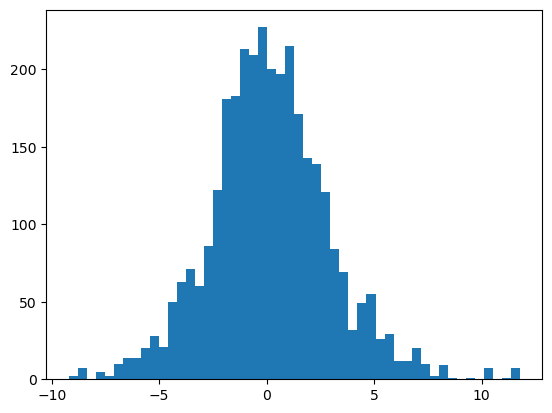

In [224]:
plt.hist(hpreact.view(-1).tolist(), 50); # very broad distribution of pre-activations (-15 to 15) so when we squash them via tanh they take a lot of extreme values.

In [225]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.5891921520233154
val 2.584827184677124


In [226]:
# loss log
# - fix softmax being confidently wrong: kaiming init (smooth out the initial distribution of odds at the start without making the neurons identical)
# - fix tanh being too saturated: what we just did.

In [227]:
# standard deviation becomes a LOT larger once we start mulitplying weights together

In [228]:
# after training, we make a single (gradient-off) pass over our complete dataset
# we use this to decide on a mean & std that we clamp so we can pass single samples through our model now
with torch.no_grad():
    emb = C[Xtr] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True) 
    bmstd = hpreact.std(0, keepdim=True)


In [229]:
bnmean

tensor([[ 0.4186,  1.3406,  0.8926,  0.2863, -0.1549, -0.5137, -0.7227, -0.3015,
          0.0525,  0.3879, -1.8891, -0.6180, -0.7803,  0.4251,  0.0519, -1.0746,
          1.1094, -0.3002,  0.0615,  0.8710,  1.3453, -1.0072,  0.4170,  0.8242,
         -0.3165,  0.6633, -0.4252, -0.0545,  0.1289,  1.4795,  0.4563,  0.4373,
         -0.9283,  0.3927,  1.5570,  1.0334, -1.1478,  1.5508,  0.0346, -0.6994,
         -0.1561, -0.0962,  1.9018, -0.3811,  1.6697,  0.3878,  0.4564,  2.1232,
          0.4228,  1.3066, -0.4680, -1.0851,  0.7672,  1.1635, -1.7571, -0.3544,
          0.2343, -0.7411, -1.0488,  0.7864,  0.3891, -0.6808,  0.0090, -0.7971,
         -0.0424, -0.5309, -0.5661, -0.7157,  1.1166, -0.4961, -0.7239, -2.0813,
          0.6647, -0.0522,  0.7800,  0.3375,  0.6800, -0.7518,  0.6285,  0.7099,
          0.3891,  0.2788,  0.9897, -0.3767, -0.3484, -0.1718,  1.8046,  1.4788,
         -0.4183, -0.7165, -0.8727, -0.8251,  0.1731,  1.4834,  0.6989,  0.4909,
         -0.4238,  0.8717,  

In [230]:
bmstd

tensor([[1.1493, 3.8478, 1.2022, 2.5929, 1.7850, 2.6546, 1.9598, 1.7226, 1.4552,
         0.9960, 3.1965, 2.0856, 3.1483, 2.2923, 2.5041, 3.0560, 1.4103, 2.7509,
         3.6695, 2.2491, 2.7344, 1.6357, 3.7017, 2.1921, 1.6906, 2.3049, 3.6542,
         1.6757, 1.0853, 2.2359, 1.2885, 3.4135, 3.4456, 2.3726, 2.3025, 3.6144,
         1.4473, 3.3617, 3.7995, 1.5054, 2.2973, 1.2499, 3.1840, 1.6088, 5.2558,
         1.9896, 1.5428, 3.5081, 2.9711, 2.7807, 2.6034, 2.6798, 1.6787, 4.7533,
         2.0630, 1.6562, 2.4703, 3.3469, 2.7606, 1.7605, 1.5332, 2.4538, 1.3583,
         1.8240, 1.4417, 1.7669, 1.8088, 1.4775, 2.8025, 1.0333, 3.6112, 3.7837,
         1.4164, 2.9236, 2.4681, 1.6222, 2.8325, 1.9686, 1.5690, 2.9258, 1.7785,
         2.1850, 2.8623, 1.1744, 1.6460, 1.8334, 1.9547, 1.9718, 2.3852, 2.3457,
         4.4222, 3.1378, 3.0762, 4.1133, 1.1774, 1.2635, 3.4776, 2.7857, 3.5226,
         3.0366]])